In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from matplotlib import pyplot as plt
%matplotlib inline

from pandas_profiling import ProfileReport
from keplergl import KeplerGl

print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Seaborn Version: " + sns.__version__)

Pandas Version: 1.2.4
Numpy Version: 1.18.5
Seaborn Version: 0.11.1


In [2]:
# Make plots larger

plt.rcParams["figure.figsize"] = (16,8)

In [3]:
trips = pd.read_csv("../data/clean/trips.csv", parse_dates=["date_from", "date_until"])
trips.sample(3)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km,speed_in_kmh
7450762,119461,32FD073CE7A44748F19589C879B6E45164E8D8F4,2017-04-27 08:22:14,2017-04-27 08:54:26,Lappenbergsallee / Bei der Apostelkirche,243618,Osakaallee/Übersee Quartier,201329,iPhone SRH,33,5.264312,9.571477
4575002,109090,46862EB320AD3347778ED2EE0EEB37158E02ADF6,2016-03-26 11:20:56,2016-03-26 11:37:23,Goebenstraße/Eppendorfer Weg,131641,Neuer Pferdemarkt / Beim Grünen Jäger,131890,iPhone CAB,17,2.082976,7.351680
5964127,120182,7CD78637242A853D7176E50B9586DFAE6401DD7B,2016-08-30 16:13:42,2016-08-30 16:29:40,Paul-Ehrlich-Straße/Asklepios Klinik Altona,247483,Bahnhof Altona West / Busbahnhof,131889,Android SRH,16,2.214407,8.304026


In [4]:
stations = pd.read_csv("../data/clean/stations.csv")
coordinates = stations[["name", "latitude", "longitude"]].set_index("name")
stations.sample(3)

,station_id,name,longitude,latitude
126,227415,Wandsbeker Chaussee/ Börnestraße,10.059528,53.570470
64,140802,Landwehr / Ramazan-Avci-Platz,10.037022,53.561109
48,138385,Lange Reihe / Lohmühlenpark,10.014900,53.559900


In [5]:
trips_per_hour_with_weather = pd.read_csv("../data/clean/station_trips_weather.csv", parse_dates=["datetime"])
trips_per_hour_with_weather.set_index("datetime", inplace=True)
trips_per_hour = trips_per_hour_with_weather[["station_name", "check_ins", "check_outs", "diff"]]
trips_per_hour.sample(3)

,station_name,check_ins,check_outs,diff
datetime,,,,
2015-04-21 12:00:00,Burgstraße/Hammer Landstraße,3,1,2
2016-05-06 17:00:00,Bahnhof Altona Ost/Max-Brauer-Allee,5,7,-2
2016-04-14 00:00:00,Hindenburgstraße/Möringbogen,0,0,0


In [171]:
stations_hourly_movements = trips_per_hour.groupby([trips_per_hour.index.hour, "station_name"]).sum()
stations_hourly_movements = stations_hourly_movements.merge(
    coordinates, left_on="station_name", right_index=True, sort=False
).reset_index()
stations_hourly_movements.to_csv("../data/kepler/stations_hourly_movements.csv", index=False)
stations_hourly_movements

,datetime,station_name,check_ins,check_outs,diff,latitude,longitude
0,0,Allende-Platz/Grindelhof,3723,4582,-859,53.567845,9.982728
1,1,Allende-Platz/Grindelhof,2912,3053,-141,53.567845,9.982728
2,2,Allende-Platz/Grindelhof,1992,1716,276,53.567845,9.982728
3,3,Allende-Platz/Grindelhof,1612,921,691,53.567845,9.982728
4,4,Allende-Platz/Grindelhof,1251,578,673,53.567845,9.982728
...,...,...,...,...,...,...,...
4987,19,Überseering/Mexikoring,840,1000,-160,53.601619,10.024745
4988,20,Überseering/Mexikoring,539,745,-206,53.601619,10.024745
4989,21,Überseering/Mexikoring,351,652,-301,53.601619,10.024745
4990,22,Überseering/Mexikoring,235,349,-114,53.601619,10.024745


In [6]:
pt_stations = gpd.read_file("../data/esri/pt_stations.geojson")
pt_lines = gpd.read_file("../data/esri/pt_lines.geojson")

first_month_stations = pd.unique(trips[trips.date_from <= pd.Timestamp("2014-01-31 23:59:59")].start_station_name)

In [7]:
hourly_mean = trips_per_hour.groupby([trips_per_hour.index, "station_name"]).mean()
hourly_mean

check_ins  \
datetime            station_name                                         
2014-01-01 00:00:00 Allende-Platz/Grindelhof                         0   
                    Alsenstraße/Düppelstraße                         3   
                    Alsterdorf Markt/Evangelische Stiftung           0   
                    Alsterdorfer Straße/Fuhlsbüttler Straße          0   
                    Alsterschwimmhalle/Ifflandstraße                 0   
...                                                                ...   
2017-05-15 11:00:00 Wiesendamm/Roggenkamp                            1   
                    Wilhelmsburger Platz/Zur Schleuse                0   
                    Winterhuder Weg/ Zimmerstraße                    2   
                    Zentralbibliothek / Münzstraße                   0   
                    Überseering/Mexikoring                           1   

                                                             check_outs  diff  
datetime            station_name                                               
2014-01-01 00:00:00 Allende-Platz/Grindelhof                          5    -5  
                    Alsenstraße/Düppelstraße                          0     3  
                    Alsterdorf Markt/Evangelische Stiftung            0     0  
                    Alsterdorfer Straße/Fuhlsbüttler Straße           0     0  
                    Alsterschwimmhalle/Ifflandstraße                  0     0  
...                                                                 ...   ...  
2017-05-15 11:00:00 Wiesendamm/Roggenkamp                             1     0  
                    Wilhelmsburger Platz/Zur Schleuse                 0     0  
                    Winterhuder Weg/ Zimmerstraße                     4    -2  
                    Zentralbibliothek / Münzstraße                    2    -2  
                    Überseering/Mexikoring                            1     0  

[6142656 rows x 3 columns]

In [8]:
hourly_mean.describe()

,check_ins,check_outs,diff
count,6.142656e+06,6.142656e+06,6.142656e+06
mean,1.236731e+00,1.236744e+00,-1.269809e-05
std,2.458370e+00,2.450619e+00,2.052585e+00
min,0.000000e+00,0.000000e+00,-9.600000e+01
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00,0.000000e+00
max,1.100000e+02,1.060000e+02,7.400000e+01


In [10]:
last_day = trips_per_hour.index.max().date()

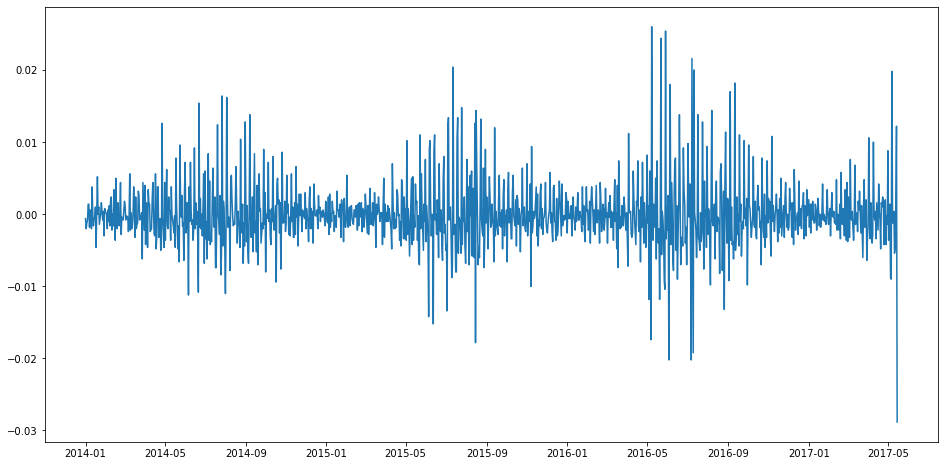

In [11]:
tmp = trips
plt.plot(trips_per_hour["diff"].resample("D").agg("mean"))
#plt.savefig("figures/duration_in_min_quantiles.png", bbox_inches="tight")
plt.show()

In [12]:
weekly_mean = trips_per_hour.groupby("station_name").resample("W").mean()
weekly_mean

check_ins  check_outs      diff
station_name             datetime                                   
Allende-Platz/Grindelhof 2014-01-05   3.175000    3.050000  0.125000
                         2014-01-12   4.345238    4.250000  0.095238
                         2014-01-19   4.547619    4.220238  0.327381
                         2014-01-26   3.166667    2.583333  0.583333
                         2014-02-02   3.267857    2.494048  0.773810
...                                        ...         ...       ...
Überseering/Mexikoring   2017-04-23   0.690476    0.613095  0.077381
                         2017-04-30   0.773810    0.761905  0.011905
                         2017-05-07   0.577381    0.571429  0.005952
                         2017-05-14   1.047619    1.077381 -0.029762
                         2017-05-21   1.500000    0.416667  1.083333

[36816 rows x 3 columns]

In [13]:
weekly_mean.describe()

,check_ins,check_outs,diff
count,36816.000000,36816.000000,36816.000000
mean,1.234564,1.234729,-0.000165
std,1.271431,1.268210,0.131767
min,0.000000,0.000000,-2.416667
25%,0.178571,0.178571,-0.041667
50%,0.904762,0.916667,0.000000
75%,1.864583,1.869048,0.029762
max,9.196429,8.833333,5.500000


In [14]:
trips_per_hour.groupby("station_name").resample("D").mean()

check_ins  check_outs      diff
station_name             datetime                                   
Allende-Platz/Grindelhof 2014-01-01   2.208333    2.500000 -0.291667
                         2014-01-02   2.750000    2.833333 -0.083333
                         2014-01-03   4.125000    3.416667  0.708333
                         2014-01-04   4.208333    3.375000  0.833333
                         2014-01-05   2.583333    3.125000 -0.541667
...                                        ...         ...       ...
Überseering/Mexikoring   2017-05-11   1.416667    1.500000 -0.083333
                         2017-05-12   0.958333    1.041667 -0.083333
                         2017-05-13   0.625000    0.666667 -0.041667
                         2017-05-14   0.708333    0.583333  0.125000
                         2017-05-15   1.500000    0.416667  1.083333

[256048 rows x 3 columns]

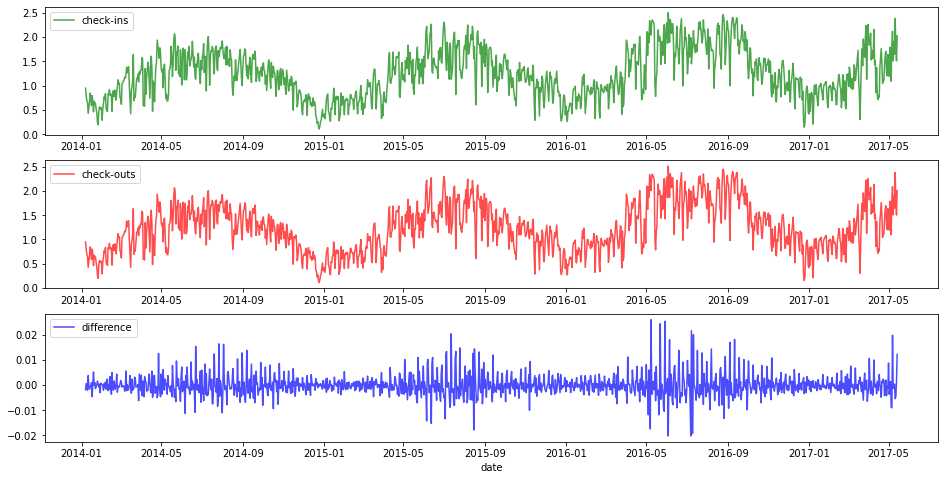

In [15]:
full_day_start_date = "2014-01-07" # first day
full_day_end_date = "2017-05-14 23:59:59" # last complete day
daily_mean = trips_per_hour[
    pd.Timestamp(full_day_start_date):pd.Timestamp(full_day_end_date)
].resample("D").mean()

fig, ax = plt.subplots(3, 1)
ax[0].plot(daily_mean["check_ins"], color="green", label="check-ins", alpha=0.7)
ax[0].legend()
ax[1].plot(daily_mean["check_outs"], color="red", label="check-outs", alpha=0.7)
ax[1].legend()
ax[2].plot(daily_mean["diff"], color="blue", label="difference", alpha=0.7)
ax[2].legend()
plt.xlabel("date")
plt.savefig("figures/stations_daily_mean.png", bbox_inches="tight")
plt.show()

In [16]:
monthly_mean = trips_per_hour.groupby("station_name").resample("M").mean()
monthly_mean

check_ins  check_outs      diff
station_name             datetime                                   
Allende-Platz/Grindelhof 2014-01-31   3.759409    3.393817  0.365591
                         2014-02-28   4.575893    4.318452  0.257440
                         2014-03-31   5.642473    5.331989  0.310484
                         2014-04-30   6.630556    6.495833  0.134722
                         2014-05-31   7.086022    6.989247  0.096774
...                                        ...         ...       ...
Überseering/Mexikoring   2017-01-31   0.448925    0.459677 -0.010753
                         2017-02-28   0.498512    0.519345 -0.020833
                         2017-03-31   0.743280    0.739247  0.004032
                         2017-04-30   0.772222    0.751389  0.020833
                         2017-05-31   0.836207    0.810345  0.025862

[8528 rows x 3 columns]

In [17]:
monthly_mean.describe()

,check_ins,check_outs,diff
count,8528.000000,8528.000000,8528.000000
mean,1.240031,1.240048,-0.000017
std,1.245236,1.242407,0.089923
min,0.000000,0.000000,-1.174731
25%,0.196429,0.199731,-0.024194
50%,0.936470,0.942828,0.000000
75%,1.872625,1.877688,0.020833
max,7.849462,7.772849,0.873656


In [39]:
yearly_mean = trips_per_hour.groupby("station_name").resample("Y").mean()
yearly_mean

check_ins  check_outs      diff
station_name                   datetime                                   
Allende-Platz/Grindelhof       2014-12-31   5.863813    5.703881  0.159932
                               2015-12-31   5.354795    5.246347  0.108447
                               2016-12-31   5.345856    5.287454  0.058402
                               2017-12-31   4.635998    4.520756  0.115242
Alsenstraße/Düppelstraße       2014-12-31   2.613128    2.605251  0.007877
...                                              ...         ...       ...
Zentralbibliothek / Münzstraße 2017-12-31   0.910161    1.002169 -0.092007
Überseering/Mexikoring         2014-12-31   0.486758    0.486416  0.000342
                               2015-12-31   0.544064    0.524087  0.019977
                               2016-12-31   0.750569    0.727687  0.022883
                               2017-12-31   0.640954    0.639405  0.001549

[832 rows x 3 columns]

In [40]:
yearly_mean.describe()

,check_ins,check_outs,diff
count,832.000000,832.000000,832.000000
mean,1.228854,1.228880,-0.000026
std,1.090391,1.086635,0.079224
min,0.000000,0.000000,-0.634703
25%,0.279984,0.277164,-0.017694
50%,0.977367,0.975663,0.000000
75%,1.953967,1.984542,0.019851
max,5.863813,5.703881,0.442379


## Selecting sample stations

### Prerequisites

* station has to be included in the data set since the beginning (January 2014)
* stations have to be somehow different from another, be it in absolute demand, demand patterns, distance to city centre, etc,

**Am Kaiserkai/Großer Grasbrook**
* is one of the most popular during rush hours
* has the highest overall diff, meaning a great imbalance and surplus in bicycle inventory
* is located close to the city centre
* has a lot of neighbouring stations

**Grindelberg / Bezirksamt Eimsbüttel**
* does not have many strong imbalanced routes but has a negative diff overall
* when comparing mean check-in count of stations, it is right in the middle
* has a medium amount of neighbouring stations

**Barkassenanleger/Mengestraße**
* has an overall diff close to zero (-50, third best)
* is located further away from the city centre and one of the few stations south of the Elbe
* has few neighbouring stations

In [41]:
sample_station_a = "Am Kaiserkai/Großer Grasbrook"
sample_station_b = "Grindelberg / Bezirksamt Eimsbüttel"
sample_station_c = "Barkassenanleger/Mengestraße"
sample_stations = [sample_station_a, sample_station_b, sample_station_c]

In [42]:
stations[
    stations.name.isin(sample_stations)
].to_csv("../data/kepler/sample_stations_location.csv", index=False)

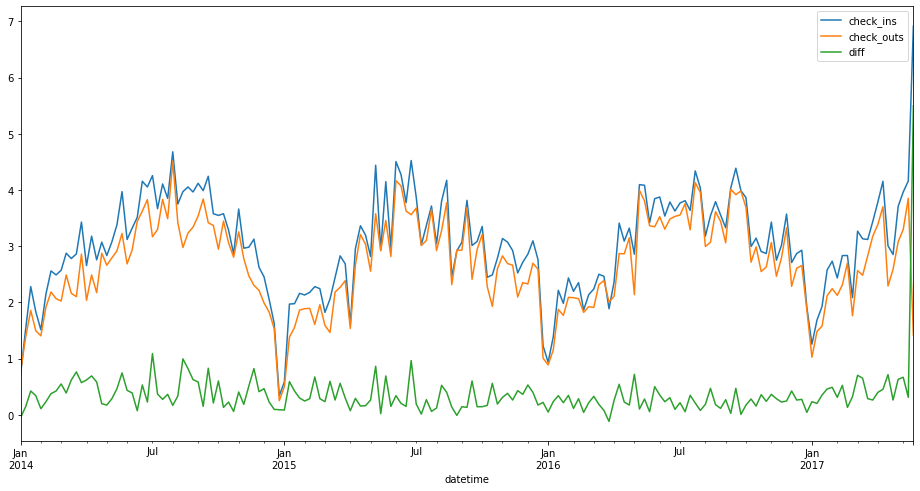

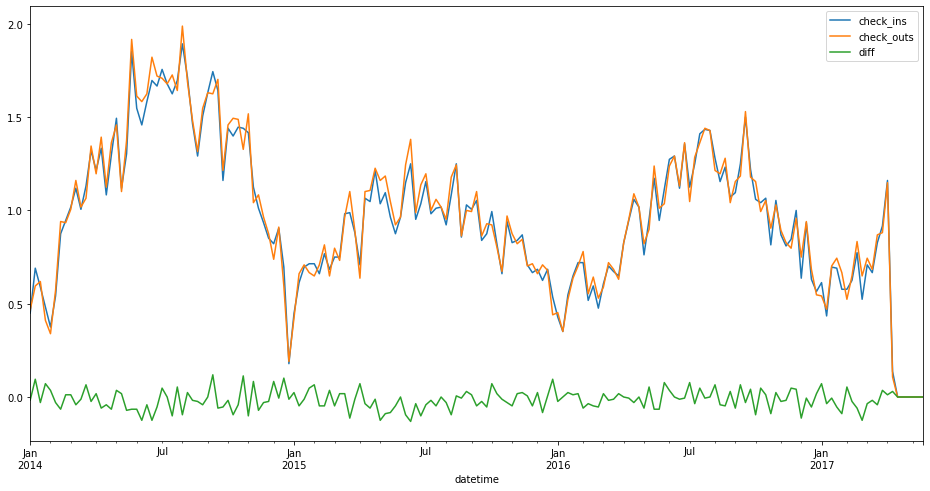

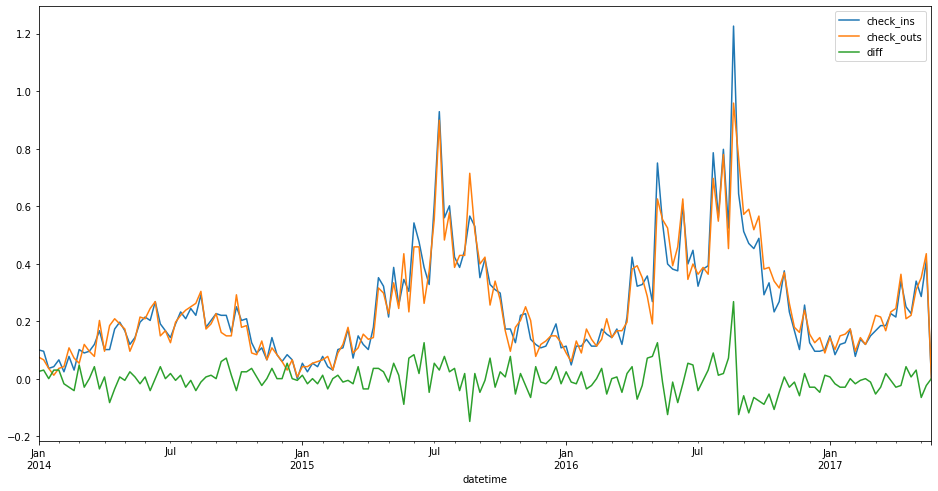

In [43]:
for sample_station in sample_stations:
    tph = trips_per_hour[trips_per_hour.station_name == sample_station][["check_ins", "check_outs", "diff"]]
    tph.resample("W").agg("mean").plot.line()

In [44]:
start_count = trips.value_counts(subset=["start_station_id"]).to_frame()
start_count.rename(columns={0: "check_outs"}, inplace=True)

end_count = trips.value_counts(subset=["end_station_id"]).to_frame()
end_count.rename(columns={0: "check_ins"}, inplace=True)

stations_count = stations.merge(start_count, left_on="station_id", right_index=True, sort=False)
stations_count = stations_count.merge(end_count, left_on="station_id", right_index=True, sort=False)
stations_count["diff"] = stations_count.apply(lambda x: x["check_ins"] - x["check_outs"], axis=1)

stations_count.sort_values(by="diff")

,station_id,name,longitude,latitude,check_outs,check_ins,diff
19,131872,Hauptbahnhof West / Glockengießer Wall,10.004553,53.553676,94646,80907,-13739
20,131873,Hauptbahnhof Ost / Hachmannplatz,10.007652,53.554307,96983,86420,-10563
32,131889,Bahnhof Altona West / Busbahnhof,9.933870,53.551800,70642,62699,-7943
108,213679,U-Bahn Schlump,9.969601,53.567991,68568,62426,-6142
16,131652,Berliner Tor / Berlinertordamm,10.024600,53.553300,79654,73947,-5707
...,...,...,...,...,...,...,...
119,218173,Rothenburgsort/Marktplatz/Lindleystraße,10.038938,53.534288,20569,25532,4963
23,131879,Jungfernstieg / Ballindamm,9.995501,53.552244,107754,113539,5785
0,131543,Landungsbrücke/Hafentor,9.972300,53.545700,89663,95542,5879
78,199402,Mannesallee/Veringstraße,9.987298,53.514265,20701,27388,6687


In [45]:
stations_count.describe()

,station_id,longitude,latitude,check_outs,check_ins,diff
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,199879.750000,10.001020,53.557640,36567.201923,36567.201923,0.000000
std,48626.097309,0.057762,0.036847,32142.215813,32244.461661,2187.707524
min,131543.000000,9.862013,53.447625,81.000000,72.000000,-13739.000000
25%,139220.750000,9.969232,53.548219,8936.250000,9031.750000,-424.250000
50%,212078.500000,9.993834,53.559731,28649.000000,28334.000000,15.000000
75%,244939.750000,10.028767,53.578009,56025.750000,57382.250000,477.000000
max,268358.000000,10.220000,53.654290,157111.000000,160339.000000,9699.000000


In [46]:
stations_count[stations_count.name == sample_station_a]

,station_id,name,longitude,latitude,check_outs,check_ins,diff
71,193238,Am Kaiserkai/Großer Grasbrook,9.992856,53.541838,79570,89269,9699


In [47]:
stations_count[stations_count.name == sample_station_b]

,station_id,name,longitude,latitude,check_outs,check_ins,diff
38,138370,Grindelberg / Bezirksamt Eimsbüttel,9.977824,53.575408,28755,28336,-419


In [48]:
stations_count[stations_count.name == sample_station_c]

,station_id,name,longitude,latitude,check_outs,check_ins,diff
124,226605,Barkassenanleger/Mengestraße,9.99647,53.499748,7244,7194,-50


In [49]:
stations_count[stations_count["diff"] >= 0].to_csv("../data/kepler/stations_overall_positive_diff.csv", index=False)
stations_count[stations_count["diff"] < 0].to_csv("../data/kepler/stations_overall_negative_diff.csv", index=False)

In [99]:
stations_count[stations_count["diff"] < 0][["diff"]].describe()

,diff
count,102.000000
mean,-1162.598039
std,2094.062139
min,-13739.000000
25%,-1334.500000
50%,-444.000000
75%,-142.500000
max,-1.000000


In [100]:
stations_count[stations_count["diff"] >= 0][["diff"]].describe()

,diff
count,106.000000
mean,1118.726415
std,1625.070580
min,6.000000
25%,180.250000
50%,459.500000
75%,1323.500000
max,9699.000000


In [52]:
stations_count[stations_count["diff"] >= 0][["diff"]].median()

diff    459.5
dtype: float64

In [53]:
stations_count[stations_count["diff"] < 0][["diff"]].median()

diff   -444.0
dtype: float64

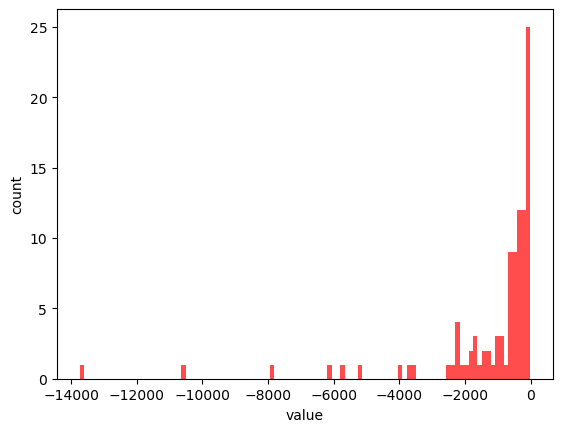

In [123]:
tmp = stations_count[stations_count["diff"] < 0][["diff"]]
plt.hist(tmp, len(tmp), density=False, color="red", alpha=0.7)
plt.xlabel("value")
plt.ylabel("count")
plt.savefig("figures/stations_diff_negative_dist.png", bbox_inches="tight")
plt.show()

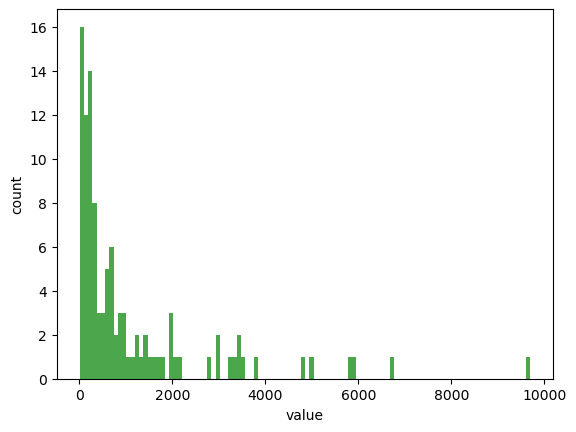

In [124]:
tmp = stations_count[stations_count["diff"] >= 0][["diff"]]
plt.hist(tmp, len(tmp), density=False, color="green", alpha=0.7)
plt.xlabel("value")
plt.ylabel("count")
plt.savefig("figures/stations_diff_positive_dist.png", bbox_inches="tight")
plt.show()

In [56]:
# stations that are present since the beginning and have a diff within a range of -50 and +50

stations_count[
    (stations_count.name.isin(first_month_stations)) &
    (stations_count["diff"].isin(range(-50,51)))
]

,station_id,name,longitude,latitude,check_outs,check_ins,diff
48,138385,Lange Reihe / Lohmühlenpark,10.014900,53.559900,107718,107716,-2
64,140802,Landwehr / Ramazan-Avci-Platz,10.037022,53.561109,45239,45273,34
124,226605,Barkassenanleger/Mengestraße,9.996470,53.499748,7244,7194,-50


In [57]:
lowest_diff = stations_count.head(5)

for station_name in lowest_diff.name:
    tmp = grouped.get_group(station_name).resample("W").agg("mean")
    ax = tmp.iloc[:-1][["check_ins", "check_outs", "diff"]].plot.line()
    ax.set_xlabel(station_name)
    plt.show()

NameError: name 'grouped' is not defined

In [ ]:
highest_diff = stations_count.tail(5)

for station_name in highest_diff.name:
    tmp = grouped.get_group(station_name).resample("W").agg("mean")
    ax = tmp.iloc[:-1][["check_ins", "check_outs", "diff"]].plot.line()
    ax.set_xlabel(station_name)
    plt.show()

In [ ]:
tmp = stations_count.sort_values(by="diff")[["name", "diff"]]
stations = pd.merge(tmp, stations, left_on="name", right_on="name", how="left", sort=False)

In [58]:
neighbour_threshold = trips.distance_in_km.quantile(0.5).round(1)
print("neighbour threshold: % s km"% neighbour_threshold)
distances = np.load("calculations/station_distances.npy", allow_pickle=True).item()

def count_neighbours(station):
    count = 0
    neighbours = distances[station.station_id]
    for neighbour_distance in neighbours.values():
        if (neighbour_distance <= neighbour_threshold):
            count = count + 1
    return count - 1 # removes itself as a neighbour


stations["neighbour_stations_count"] = stations.apply(count_neighbours, axis=1)
stations.sample(5)

neighbour threshold: 1.6 km


,station_id,name,longitude,latitude,neighbour_stations_count
160,244946,Dürerstraße/Beslerplatz- S Bahn Othmarschen,9.887159,53.560395,2
152,244936,Sievekingsallee/Sievekingdamm,10.052589,53.560835,13
194,254725,Vierlandenstraße/Johann-Adolf-Hasse-Platz,10.210913,53.488449,3
161,245203,Alsterdorfer Straße/Fuhlsbüttler Straße,10.032000,53.620000,3
76,198086,Eppendorfer Weg/Hoheluftchaussee,9.971720,53.581771,20


In [59]:
stations[stations.name == sample_station_a]

,station_id,name,longitude,latitude,neighbour_stations_count
71,193238,Am Kaiserkai/Großer Grasbrook,9.992856,53.541838,28


In [60]:
stations[stations.name == sample_station_b]

,station_id,name,longitude,latitude,neighbour_stations_count
38,138370,Grindelberg / Bezirksamt Eimsbüttel,9.977824,53.575408,19


In [61]:
stations[stations.name == sample_station_c]

,station_id,name,longitude,latitude,neighbour_stations_count
124,226605,Barkassenanleger/Mengestraße,9.99647,53.499748,3


In [62]:
stations.sort_values(by="neighbour_stations_count")

,station_id,name,longitude,latitude,neighbour_stations_count
78,199402,Mannesallee/Veringstraße,9.987298,53.514265,0
178,252486,Randstraße/ Stellingen,9.919356,53.590248,0
171,250340,Hugo-Kirchberg-Straße/Tesa,9.985280,53.654290,0
167,247847,Nordalbinger Weg/Paul-Sorge-Straße,9.950095,53.640835,0
166,247846,Niendorf Markt/Tibarg,9.951311,53.619072,0
...,...,...,...,...,...
44,138380,Jungfernstieg / Neuer Jungfernstieg,9.991400,53.555000,39
24,131880,Mönckebergstraße / Rosenstraße,9.997140,53.550722,39
68,163327,Axel-Springer-Platz/Wexstraße,9.985161,53.551853,40
46,138383,Kleine Rosenstraße / Gerhart-Hauptmann-Platz,9.998430,53.551600,40


In [63]:
config = eval(open("config/map_config_most_popular.py", "r").read())
KeplerGl(
    height=700, 
    data={
        "negative": stations[stations["diff"] < 0], 
        "positive": stations[stations["diff"] >= 0],
        "pt_stations": pt_stations,
        "pt_lines": pt_lines,
    },
    config=config
)

KeyError: 'diff'

## Identify most imbalanced pairs per hour

In [64]:
# Count monthly checkouts from a station and group by destination station
hourly_checkouts = trips[["date_from", "start_station_name", "end_station_name"]].groupby(
    [trips.date_from.dt.hour, "start_station_name", "end_station_name"]
).agg("count")
hourly_checkouts.rename(columns={"date_from": "checkout_count"}, inplace=True)

# Count monthly checkins to a station and group by origin station
hourly_checkins = trips[["date_until", "end_station_name", "start_station_name"]].groupby(
    [trips.date_from.dt.hour, "end_station_name", "start_station_name"]
).agg("count")
hourly_checkins.rename(columns={"date_until": "checkin_count"}, inplace=True)

hourly_pair_movement = hourly_checkouts.copy()
hourly_pair_movement.loc[:, "checkin_count"] = hourly_checkins
hourly_pair_movement.fillna(0, inplace=True)
hourly_pair_movement["checkin_count"] = hourly_pair_movement["checkin_count"].astype(int)
hourly_pair_movement["diff"] = hourly_pair_movement["checkin_count"] - hourly_pair_movement["checkout_count"]

hourly_pair_movement

checkout_count  \
date_from start_station_name       end_station_name                                     
0         Allende-Platz/Grindelhof Allende-Platz/Grindelhof                       112   
                                   Alsenstraße/Düppelstraße                        79   
                                   Alsterschwimmhalle/Ifflandstraße                13   
                                   Am Kaiserkai/Großer Grasbrook                    4   
                                   Amsinckstraße/ Nordkanalbrücke                  19   
...                                                                               ...   
23        Überseering/Mexikoring   Weidestraße /Johannes-Prassek-Park               2   
                                   Weidestraße/Biedermannplatz                      7   
                                   Wiesendamm/Roggenkamp                            9   
                                   Winterhuder Weg/ Zimmerstraße                    1   
                                   Überseering/Mexikoring                          11   

                                                                       checkin_count  \
date_from start_station_name       end_station_name                                    
0         Allende-Platz/Grindelhof Allende-Platz/Grindelhof                      112   
                                   Alsenstraße/Düppelstraße                       41   
                                   Alsterschwimmhalle/Ifflandstraße                6   
                                   Am Kaiserkai/Großer Grasbrook                  11   
                                   Amsinckstraße/ Nordkanalbrücke                  6   
...                                                                              ...   
23        Überseering/Mexikoring   Weidestraße /Johannes-Prassek-Park              0   
                                   Weidestraße/Biedermannplatz                     1   
                                   Wiesendamm/Roggenkamp                          23   
                                   Winterhuder Weg/ Zimmerstraße                   0   
                                   Überseering/Mexikoring                         11   

                                                                       diff  
date_from start_station_name       end_station_name                          
0         Allende-Platz/Grindelhof Allende-Platz/Grindelhof               0  
                                   Alsenstraße/Düppelstraße             -38  
                                   Alsterschwimmhalle/Ifflandstraße      -7  
                                   Am Kaiserkai/Großer Grasbrook          7  
                                   Amsinckstraße/ Nordkanalbrücke       -13  
...                                                                     ...  
23        Überseering/Mexikoring   Weidestraße /Johannes-Prassek-Park    -2  
                                   Weidestraße/Biedermannplatz           -6  
                                   Wiesendamm/Roggenkamp                 14  
                                   Winterhuder Weg/ Zimmerstraße         -1  
                                   Überseering/Mexikoring                 0  

[369081 rows x 3 columns]

In [172]:
# Movement is symmetrical.
# If n bikes arrived at station X from station Y, then n bikes moved from station Y to station X.
# So either all positive or all negative values can be examined.

imbalanced_pairs = hourly_pair_movement[hourly_pair_movement["diff"] > 0]
imbalanced_pairs = imbalanced_pairs.merge(coordinates, left_on="start_station_name", right_index=True, sort=False)
imbalanced_pairs = imbalanced_pairs.merge(coordinates, left_on="end_station_name", right_index=True, sort=False)
imbalanced_pairs.rename(
    columns={ "start_station_name": "station_x", "end_station_name": "station_y", "date_from": "hour" }, 
    inplace=True
)

# Adjustments for kepler
imbalanced_pairs.reset_index(inplace=True)
#imbalanced_pairs["date_from"] = pd.to_datetime({"year": 2016, "month": 6, "day": 7, "hour": imbalanced_pairs["date_from"]})
imbalanced_pairs.to_csv("../data/kepler/stations_imbalanced_pairs.csv", index=False)
imbalanced_pairs

,date_from,start_station_name,end_station_name,checkout_count,checkin_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
0,0,Allende-Platz/Grindelhof,Am Kaiserkai/Großer Grasbrook,4,11,7,53.567845,9.982728,53.541838,9.992856
1,6,Allende-Platz/Grindelhof,Am Kaiserkai/Großer Grasbrook,2,4,2,53.567845,9.982728,53.541838,9.992856
2,12,Allende-Platz/Grindelhof,Am Kaiserkai/Großer Grasbrook,13,14,1,53.567845,9.982728,53.541838,9.992856
3,13,Allende-Platz/Grindelhof,Am Kaiserkai/Großer Grasbrook,15,26,11,53.567845,9.982728,53.541838,9.992856
4,15,Allende-Platz/Grindelhof,Am Kaiserkai/Großer Grasbrook,8,29,21,53.567845,9.982728,53.541838,9.992856
...,...,...,...,...,...,...,...,...,...,...
130967,10,Bahnhof Bergedorf/Johann-Meyer-Straße,Lohbrügger Markt/Ludwig-Rosenberg-Ring,12,29,17,53.490496,10.206105,53.494675,10.206894
130968,11,Bahnhof Bergedorf/Johann-Meyer-Straße,Lohbrügger Markt/Ludwig-Rosenberg-Ring,13,36,23,53.490496,10.206105,53.494675,10.206894
130969,12,Bahnhof Bergedorf/Johann-Meyer-Straße,Lohbrügger Markt/Ludwig-Rosenberg-Ring,17,39,22,53.490496,10.206105,53.494675,10.206894
130970,13,Bahnhof Bergedorf/Johann-Meyer-Straße,Lohbrügger Markt/Ludwig-Rosenberg-Ring,13,45,32,53.490496,10.206105,53.494675,10.206894


In [180]:
imbalanced_pairs["diff"].quantile(0.99)

182.0

In [66]:
# Normalise diff to import in kepler and filter by hours of the day
# Required because kepler filter is not able to include both hours 0 and 23

import pandas as pd
from sklearn import preprocessing

normalised_diff = imbalanced_pairs.copy()
normalised_diff["diff"] = preprocessing.MinMaxScaler().fit_transform(normalised_diff[["diff"]])
normalised_diff["diff"] = normalised_diff["diff"] * 100

In [67]:
time_frame_night = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5]
time_frame_morning = [7, 8, 9]
time_frame_afternoon = [10, 11, 12, 13, 14, 15]
time_frame_evening = [16, 17, 18, 19]

normalised_diff[
    imbalanced_pairs.date_from.isin(time_frame_night)
].to_csv("../data/kepler/stations_imbalanced_pairs_night.csv", index=False)
normalised_diff[
    imbalanced_pairs.date_from.isin(time_frame_morning)
].to_csv("../data/kepler/stations_imbalanced_pairs_morning.csv", index=False)
normalised_diff[
    imbalanced_pairs.date_from.isin(time_frame_afternoon)
].to_csv("../data/kepler/stations_imbalanced_pairs_afternoon.csv", index=False)
normalised_diff[
    imbalanced_pairs.date_from.isin(time_frame_evening)
].to_csv("../data/kepler/stations_imbalanced_pairs_evening.csv", index=False)

In [68]:
config = eval(open("config/map_config_most_imbalanced.py", "r").read())
map = KeplerGl(
    height=700,
    data={ "data": imbalanced_pairs },
    config=config
)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'xuhfn9', 'type': '…

## Identify most imbalanced pairs per month

In [69]:
# Count monthly checkouts from a station and group by destination station
monthly_checkouts = trips[["date_from", "start_station_name", "end_station_name"]].groupby(
    [trips.date_from.dt.to_period("M"), "start_station_name", "end_station_name"]
).agg("count")
monthly_checkouts.rename(columns={"date_from": "checkout_count"}, inplace=True)

# Count monthly checkins to a station and group by origin station
monthly_checkins = trips[["date_from", "end_station_name", "start_station_name"]].groupby(
    [trips.date_from.dt.to_period("M"), "end_station_name", "start_station_name"]
).agg("count")
monthly_checkins.rename(columns={"date_from": "checkin_count"}, inplace=True)

monthly_pair_movement = monthly_checkouts.copy()
monthly_pair_movement.loc[:, "checkin_count"] = monthly_checkins
monthly_pair_movement.fillna(0, inplace=True)
monthly_pair_movement["checkin_count"] = monthly_pair_movement["checkin_count"].astype(int)
monthly_pair_movement["diff"] = monthly_pair_movement["checkin_count"] - monthly_pair_movement["checkout_count"]

monthly_pair_movement

checkout_count  \
date_from start_station_name       end_station_name                                     
2014-01   Allende-Platz/Grindelhof Allende-Platz/Grindelhof                        54   
                                   Alsenstraße/Düppelstraße                        20   
                                   Alsterschwimmhalle/Ifflandstraße                 6   
                                   Alter Wall/Adolphsbrücke                         2   
                                   Am Kaiserkai/Großer Grasbrook                    2   
...                                                                               ...   
2017-05   Überseering/Mexikoring   Weidestraße /Johannes-Prassek-Park               4   
                                   Weidestraße/Biedermannplatz                      3   
                                   Wiesendamm/Roggenkamp                           30   
                                   Winterhuder Weg/ Zimmerstraße                    4   
                                   Überseering/Mexikoring                           3   

                                                                       checkin_count  \
date_from start_station_name       end_station_name                                    
2014-01   Allende-Platz/Grindelhof Allende-Platz/Grindelhof                       54   
                                   Alsenstraße/Düppelstraße                       31   
                                   Alsterschwimmhalle/Ifflandstraße                7   
                                   Alter Wall/Adolphsbrücke                        4   
                                   Am Kaiserkai/Großer Grasbrook                   2   
...                                                                              ...   
2017-05   Überseering/Mexikoring   Weidestraße /Johannes-Prassek-Park             11   
                                   Weidestraße/Biedermannplatz                     2   
                                   Wiesendamm/Roggenkamp                          21   
                                   Winterhuder Weg/ Zimmerstraße                   2   
                                   Überseering/Mexikoring                          3   

                                                                       diff  
date_from start_station_name       end_station_name                          
2014-01   Allende-Platz/Grindelhof Allende-Platz/Grindelhof               0  
                                   Alsenstraße/Düppelstraße              11  
                                   Alsterschwimmhalle/Ifflandstraße       1  
                                   Alter Wall/Adolphsbrücke               2  
                                   Am Kaiserkai/Großer Grasbrook          0  
...                                                                     ...  
2017-05   Überseering/Mexikoring   Weidestraße /Johannes-Prassek-Park     7  
                                   Weidestraße/Biedermannplatz           -1  
                                   Wiesendamm/Roggenkamp                 -9  
                                   Winterhuder Weg/ Zimmerstraße         -2  
                                   Überseering/Mexikoring                 0  

[570394 rows x 3 columns]

In [70]:
# Movement is symmetrical.
# If n bikes arrived at station X from station Y, then n bikes moved from station Y to station X.
# So either all positive or all negative values can be examined.

imbalanced_pairs = monthly_pair_movement[monthly_pair_movement["diff"] > 0]
imbalanced_pairs = imbalanced_pairs.reset_index().set_index("date_from")
imbalanced_pairs = imbalanced_pairs.merge(coordinates, left_on="start_station_name", right_index=True, sort=False)
imbalanced_pairs = imbalanced_pairs.merge(coordinates, left_on="end_station_name", right_index=True, sort=False)
imbalanced_pairs.rename(
    columns={ "start_station_name": "station_x", "end_station_name": "station_y" }, 
    inplace=True
)

# Adjustments for kepler
imbalanced_pairs.index = imbalanced_pairs.index.to_timestamp()
imbalanced_pairs.reset_index(inplace=True)
imbalanced_pairs

,date_from,station_x,station_y,checkout_count,checkin_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
0,2014-01-01,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,20,31,11,53.567845,9.982728,53.563037,9.948345
1,2014-02-01,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,23,34,11,53.567845,9.982728,53.563037,9.948345
2,2014-10-01,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,66,77,11,53.567845,9.982728,53.563037,9.948345
3,2015-01-01,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,27,34,7,53.567845,9.982728,53.563037,9.948345
4,2015-04-01,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,40,51,11,53.567845,9.982728,53.563037,9.948345
...,...,...,...,...,...,...,...,...,...,...
210933,2017-03-01,Vierlandenstraße/Johann-Adolf-Hasse-Platz,Bahnhof Bergedorf/Johann-Meyer-Straße,1,8,7,53.488449,10.210913,53.490496,10.206105
210934,2017-05-01,Vierlandenstraße/Johann-Adolf-Hasse-Platz,Bahnhof Bergedorf/Johann-Meyer-Straße,2,9,7,53.488449,10.210913,53.490496,10.206105
210935,2016-05-01,Wentorfer Straße/Bezirksamt Bergedorf,Bahnhof Bergedorf/Johann-Meyer-Straße,67,73,6,53.487427,10.220000,53.490496,10.206105
210936,2016-06-01,Wentorfer Straße/Bezirksamt Bergedorf,Bahnhof Bergedorf/Johann-Meyer-Straße,150,151,1,53.487427,10.220000,53.490496,10.206105


In [71]:
imbalanced_pairs["diff"].quantile(0.75)

7.0

In [72]:
imbalanced_pairs[imbalanced_pairs["diff"] > 7]["diff"].describe()

count    49270.000000
mean        15.645931
std         11.961296
min          8.000000
25%          9.000000
50%         12.000000
75%         17.000000
max        205.000000
Name: diff, dtype: float64

In [73]:
config = eval(open("config/map_config_most_imbalanced.py", "r").read())
map = KeplerGl(
    height=700,
    data={ "data": imbalanced_pairs[imbalanced_pairs["diff"] > 7] },
    config=config
)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'xuhfn9', 'type': '…

## Identify most imbalanced pairs overall

In [149]:
# Count checkouts from a station and group by destination station
checkouts = trips[["date_from", "start_station_name", "end_station_name"]].groupby(
    ["start_station_name", "end_station_name"]
).agg("count")
checkouts.rename(columns={"date_from": "checkout_count"}, inplace=True)

# Count checkins to a station and group by origin station
checkins = trips[["date_until", "end_station_name", "start_station_name"]].groupby(
    ["end_station_name", "start_station_name"]
).agg("count")
checkins.rename(columns={"date_until": "checkin_count"}, inplace=True)

movements = checkouts.copy()
movements.loc[:, "checkin_count"] = checkins
movements.fillna(0, inplace=True)
movements["checkin_count"] = movements["checkin_count"].astype(int)
movements["diff"] = movements["checkin_count"] - movements["checkout_count"]

movements

checkout_count  \
start_station_name       end_station_name                                          
Allende-Platz/Grindelhof Allende-Platz/Grindelhof                           4112   
                         Alsenstraße/Düppelstraße                           1705   
                         Alsterdorf Markt/Evangelische Stiftung               17   
                         Alsterdorfer Straße/Fuhlsbüttler Straße               5   
                         Alsterschwimmhalle/Ifflandstraße                    338   
...                                                                          ...   
Überseering/Mexikoring   Weidestraße/Biedermannplatz                         188   
                         Wiesendamm/Roggenkamp                              1172   
                         Winterhuder Weg/ Zimmerstraße                       239   
                         Zentralbibliothek / Münzstraße                        3   
                         Überseering/Mexikoring                              626   

                                                                  checkin_count  \
start_station_name       end_station_name                                         
Allende-Platz/Grindelhof Allende-Platz/Grindelhof                          4112   
                         Alsenstraße/Düppelstraße                          1568   
                         Alsterdorf Markt/Evangelische Stiftung              17   
                         Alsterdorfer Straße/Fuhlsbüttler Straße              1   
                         Alsterschwimmhalle/Ifflandstraße                   309   
...                                                                         ...   
Überseering/Mexikoring   Weidestraße/Biedermannplatz                        314   
                         Wiesendamm/Roggenkamp                             1255   
                         Winterhuder Weg/ Zimmerstraße                      138   
                         Zentralbibliothek / Münzstraße                       1   
                         Überseering/Mexikoring                             626   

                                                                  diff  
start_station_name       end_station_name                               
Allende-Platz/Grindelhof Allende-Platz/Grindelhof                    0  
                         Alsenstraße/Düppelstraße                 -137  
                         Alsterdorf Markt/Evangelische Stiftung      0  
                         Alsterdorfer Straße/Fuhlsbüttler Straße    -4  
                         Alsterschwimmhalle/Ifflandstraße          -29  
...                                                                ...  
Überseering/Mexikoring   Weidestraße/Biedermannplatz               126  
                         Wiesendamm/Roggenkamp                      83  
                         Winterhuder Weg/ Zimmerstraße            -101  
                         Zentralbibliothek / Münzstraße             -2  
                         Überseering/Mexikoring                      0  

[26085 rows x 3 columns]

In [75]:
def extract_movements(sample_station, filename):
    tmp = movements.loc[[sample_station]].reset_index()
    tmp = tmp.merge(coordinates, left_on="start_station_name", right_index=True, sort=False)
    tmp = tmp.merge(coordinates, left_on="end_station_name", right_index=True, sort=False)
    tmp = tmp.rename(columns={ "start_station_name": "station_x", "end_station_name": "station_y" })
    filename_pos = "../data/kepler/% s_connections_pos.csv"%filename
    filename_neg = "../data/kepler/% s_connections_neg.csv"%filename
    tmp[tmp["diff"] >= 0].to_csv(filename_pos, index=False)
    tmp[tmp["diff"] < 0].to_csv(filename_neg, index=False)
    return tmp

In [76]:
sample_station_a_movements = extract_movements(sample_station_a, "sample_station_a")
sample_station_b_movements = extract_movements(sample_station_b, "sample_station_b")
sample_station_c_movements = extract_movements(sample_station_c, "sample_station_c")

In [152]:
movements_kepler = movements.reset_index()
movements_kepler = movements_kepler.merge(coordinates, left_on="start_station_name", right_index=True, sort=False)
movements_kepler = movements_kepler.merge(coordinates, left_on="end_station_name", right_index=True, sort=False)
movements_kepler.rename(columns={ "start_station_name": "station_x", "end_station_name": "station_y" })
movements_kepler.to_csv("../data/kepler/movements.csv", index=False)

movements_kepler

,start_station_name,end_station_name,checkout_count,checkin_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
0,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,4112,4112,0,53.567845,9.982728,53.567845,9.982728
169,Alsenstraße/Düppelstraße,Allende-Platz/Grindelhof,1568,1705,137,53.563037,9.948345,53.567845,9.982728
327,Alsterdorf Markt/Evangelische Stiftung,Allende-Platz/Grindelhof,17,17,0,53.612091,10.023946,53.567845,9.982728
409,Alsterdorfer Straße/Fuhlsbüttler Straße,Allende-Platz/Grindelhof,1,5,4,53.620000,10.032000,53.567845,9.982728
499,Alsterschwimmhalle/Ifflandstraße,Allende-Platz/Grindelhof,309,338,29,53.560781,10.022148,53.567845,9.982728
...,...,...,...,...,...,...,...,...,...
19623,Randstraße/ Stellingen,Nordalbinger Weg/Paul-Sorge-Straße,2,0,-2,53.590248,9.919356,53.640835,9.950095
20259,Röntgenstraße/Philips,Nordalbinger Weg/Paul-Sorge-Straße,9,7,-2,53.623481,10.012209,53.640835,9.950095
21207,Siemersplatz/Kollaustraße,Nordalbinger Weg/Paul-Sorge-Straße,54,56,2,53.600072,9.963929,53.640835,9.950095
22604,Süderfeldstraße/Universitätsklinikum Eppendorf,Nordalbinger Weg/Paul-Sorge-Straße,5,4,-1,53.594000,9.973000,53.640835,9.950095


In [153]:
most_negative = movements.loc[
    ["Hauptbahnhof West / Glockengießer Wall", "Hauptbahnhof Ost / Hachmannplatz"]
].reset_index()
most_negative = most_negative.merge(coordinates, left_on="start_station_name", right_index=True, sort=False)
most_negative = most_negative.merge(coordinates, left_on="end_station_name", right_index=True, sort=False)
most_negative.rename(columns={ "start_station_name": "station_x", "end_station_name": "station_y" })
most_negative.to_csv("../data/kepler/movements_most_negative.csv", index=False)

most_positive = movements.loc[
    ["Am Kaiserkai/Großer Grasbrook", "Mannesallee/Veringstraße"]
].reset_index()
most_positive = most_positive.merge(coordinates, left_on="start_station_name", right_index=True, sort=False)
most_positive = most_positive.merge(coordinates, left_on="end_station_name", right_index=True, sort=False)
most_positive.rename(columns={ "start_station_name": "station_x", "end_station_name": "station_y" })
most_positive.to_csv("../data/kepler/movements_most_positive.csv", index=False)

#config = eval(open("config/map_sample_station_connections.py", "r").read())
map = KeplerGl(
    height=700,
    data={
        "most_negative": most_negative,
        "most_positive": most_positive,
    },
    #config=config
)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'most_negative':                          start_station_name  \
0    Hauptbahnhof West / Glocke…

In [77]:
config = eval(open("config/map_sample_station_connections.py", "r").read())
map = KeplerGl(
    height=700,
    data={
        "sample_a_diff_pos": sample_station_a_movements[sample_station_a_movements["diff"] >= 0],
        "sample_a_diff_neg": sample_station_a_movements[sample_station_a_movements["diff"] < 0],
        "sample_b_diff_pos": sample_station_b_movements[sample_station_b_movements["diff"] >= 0],
        "sample_b_diff_neg": sample_station_b_movements[sample_station_b_movements["diff"] < 0],
        "sample_c_diff_pos": sample_station_c_movements[sample_station_c_movements["diff"] >= 0],
        "sample_c_diff_neg": sample_station_c_movements[sample_station_c_movements["diff"] < 0],
    },
    config=config
)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '57kzr3', 'type': '…

In [78]:
# Movement is symmetrical for the whole data set!
# If n bikes arrived at station X from station Y, then n bikes moved from station Y to station X.
# So either all positive or all negative values can be examined.

imbalances = movements[movements["diff"] > 0].reset_index()
imbalances = imbalances.merge(coordinates, left_on="start_station_name", right_index=True, sort=False)
imbalances = imbalances.merge(coordinates, left_on="end_station_name", right_index=True, sort=False)
imbalances.rename(
    columns={ "start_station_name": "station_x", "end_station_name": "station_y" }, 
    inplace=True
)
imbalances

,station_x,station_y,checkout_count,checkin_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
0,Allende-Platz/Grindelhof,Alter Wall/Adolphsbrücke,422,427,5,53.567845,9.982728,53.550193,9.990110
226,Alsterschwimmhalle/Ifflandstraße,Alter Wall/Adolphsbrücke,125,129,4,53.560781,10.022148,53.550193,9.990110
548,Auf dem Sande/Kehrwieder-MiniaturWunderland,Alter Wall/Adolphsbrücke,379,725,346,53.543731,9.989710,53.550193,9.990110
726,Bahnhof Altona Ost/Max-Brauer-Allee,Alter Wall/Adolphsbrücke,144,165,21,53.552121,9.936005,53.550193,9.990110
908,Bahnhof Dammtor Süd / Marseiller Straße,Alter Wall/Adolphsbrücke,451,657,206,53.560200,9.989630,53.550193,9.990110
...,...,...,...,...,...,...,...,...,...
6919,Lohbrügger Markt/Ludwig-Rosenberg-Ring,S Nettelnburg/Friedrich-Frank-Bogen,58,73,15,53.494675,10.206894,53.488482,10.182199
11092,Vierlandenstraße/Johann-Adolf-Hasse-Platz,S Nettelnburg/Friedrich-Frank-Bogen,99,117,18,53.488449,10.210913,53.488482,10.182199
9187,S Nettelnburg/Friedrich-Frank-Bogen,Bahnhof Bergedorf/Johann-Meyer-Straße,231,285,54,53.488482,10.182199,53.490496,10.206105
11089,Vierlandenstraße/Johann-Adolf-Hasse-Platz,Bahnhof Bergedorf/Johann-Meyer-Straße,185,216,31,53.488449,10.210913,53.490496,10.206105


In [79]:
imbalances[imbalances.station_x == "Grindelberg / Bezirksamt Eimsbüttel"].sort_values(by="diff")

,station_x,station_y,checkout_count,checkin_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
3711,Grindelberg / Bezirksamt Eimsbüttel,Stadthausbrücke / Neuer Wall,31,32,1,53.575408,9.977824,53.549672,9.986594
3721,Grindelberg / Bezirksamt Eimsbüttel,Versmannstraße/Am Hannoverschen Bahnhof,6,7,1,53.575408,9.977824,53.540782,10.006168
3674,Grindelberg / Bezirksamt Eimsbüttel,Fuhlsbüttler Straße/Hellbrookstraße,4,5,1,53.575408,9.977824,53.591460,10.044508
3678,Grindelberg / Bezirksamt Eimsbüttel,Habichtstraße/Steilshooper Straße,3,4,1,53.575408,9.977824,53.593726,10.050640
3679,Grindelberg / Bezirksamt Eimsbüttel,Hasselbrookstraße/Papenstraße,2,3,1,53.575408,9.977824,53.564805,10.054679
...,...,...,...,...,...,...,...,...,...
3703,Grindelberg / Bezirksamt Eimsbüttel,Paulinenplatz/Wohlwillstraße,173,271,98,53.575408,9.977824,53.554200,9.962460
3681,Grindelberg / Bezirksamt Eimsbüttel,Hauptbahnhof West / Glockengießer Wall,277,458,181,53.575408,9.977824,53.553676,10.004553
3716,Grindelberg / Bezirksamt Eimsbüttel,U-Bahn Schlump,505,793,288,53.575408,9.977824,53.567991,9.969601
3699,Grindelberg / Bezirksamt Eimsbüttel,Millerntorplatz/St.Pauli,197,514,317,53.575408,9.977824,53.551000,9.970330


In [80]:
imbalances[imbalances.station_x == "Am Kaiserkai/Großer Grasbrook"].sort_values(by="diff")

,station_x,station_y,checkout_count,checkin_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
422,Am Kaiserkai/Großer Grasbrook,Friedensallee/Hegarstraße ( S Bahn Bahrenfeld ),4,5,1,53.541838,9.992856,53.560260,9.908946
459,Am Kaiserkai/Großer Grasbrook,Paul-Ehrlich-Straße/Asklepios Klinik Altona,1,2,1,53.541838,9.992856,53.554433,9.900752
466,Am Kaiserkai/Großer Grasbrook,Schloßstrasse/Schloßgarten,10,11,1,53.541838,9.992856,53.571664,10.068644
469,Am Kaiserkai/Großer Grasbrook,Sievekingsallee/Sievekingdamm,11,12,1,53.541838,9.992856,53.560835,10.052589
464,Am Kaiserkai/Großer Grasbrook,Saarlandstraße/Wiesendamm,2,4,2,53.541838,9.992856,53.588735,10.032680
...,...,...,...,...,...,...,...,...,...
467,Am Kaiserkai/Großer Grasbrook,Schopenstehl/Alter Fischmarkt,1387,2174,787,53.541838,9.992856,53.548703,9.997126
453,Am Kaiserkai/Großer Grasbrook,Meßberg / Willy-Brandt-Straße,7803,8721,918,53.541838,9.992856,53.547805,9.998774
473,Am Kaiserkai/Großer Grasbrook,Steinstraße / Deichtorplatz,1239,2593,1354,53.541838,9.992856,53.548562,10.005325
441,Am Kaiserkai/Großer Grasbrook,Landungsbrücke/Hafentor,9116,11201,2085,53.541838,9.992856,53.545700,9.972300


In [81]:
imbalances[imbalances.station_x == "Barkassenanleger/Mengestraße"].sort_values(by="diff") # 23 entries

,station_x,station_y,checkout_count,checkin_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
1075,Barkassenanleger/Mengestraße,Jacobikirche / Steinstraße,1,2,1,53.499748,9.99647,53.550300,10.001500
1078,Barkassenanleger/Mengestraße,Millerntorplatz/St.Pauli,14,15,1,53.499748,9.99647,53.551000,9.970330
1084,Barkassenanleger/Mengestraße,Schulterblatt/Eifflerstraße,1,2,1,53.499748,9.99647,53.562709,9.960990
1077,Barkassenanleger/Mengestraße,Kurt-Schumacher-Allee / Nagelsweg,8,10,2,53.499748,9.99647,53.551700,10.016000
1089,Barkassenanleger/Mengestraße,Zentralbibliothek / Münzstraße,1,3,2,53.499748,9.99647,53.550332,10.008849
1073,Barkassenanleger/Mengestraße,Hauptbahnhof West / Glockengießer Wall,2,5,3,53.499748,9.99647,53.553676,10.004553
1085,Barkassenanleger/Mengestraße,Steinstraße / Deichtorplatz,3,6,3,53.499748,9.99647,53.548562,10.005325
1071,Barkassenanleger/Mengestraße,Hammerbrook / Sachsenfeld,49,53,4,53.499748,9.99647,53.546011,10.024042
1086,Barkassenanleger/Mengestraße,U-Bahn Baumwall,3,7,4,53.499748,9.99647,53.544279,9.980896
1068,Barkassenanleger/Mengestraße,Amsinckstraße/ Nordkanalbrücke,1,7,6,53.499748,9.99647,53.547868,10.012361


In [82]:
imbalances.sort_values(by="diff", ascending=False).head(15)

,station_x,station_y,checkout_count,checkin_count,diff,latitude_x,longitude_x,latitude_y,longitude_y
10984,Universität / Schlüterstraße,Hallerstraße / Rohtenbaumchaussee,7807,11960,4153,53.566972,9.986076,53.572081,9.988801
791,Bahnhof Altona West / Busbahnhof,Bahrenfelder Straße/Völckersstraße,15733,19582,3849,53.551800,9.933870,53.556897,9.927945
477,Am Kaiserkai/Großer Grasbrook,U-Bahn Baumwall,8889,12607,3718,53.541838,9.992856,53.544279,9.980896
7939,Mönckebergstraße / Steintorwall,Am Kaiserkai/Großer Grasbrook,4213,7787,3574,53.551600,10.005400,53.541838,9.992856
73,Allende-Platz/Grindelhof,U-Bahn Schlump,2577,5166,2589,53.567845,9.982728,53.567991,9.969601
9330,Schleidenstraße/Osterbekstraße,Saarlandstraße/Wiesendamm,12995,15568,2573,53.584582,10.033690,53.588735,10.032680
7287,Mannesallee/Veringstraße,Wilhelmsburger Platz/Zur Schleuse,4630,7153,2523,53.514265,9.987298,53.522794,10.014810
2530,Eiffestrasse/Normannenweg,Berliner Tor / Berlinertordamm,2371,4717,2346,53.552123,10.030364,53.553300,10.024600
1828,Burgstraße/Hammer Landstraße,Berliner Tor / Berlinertordamm,3573,5861,2288,53.555693,10.041298,53.553300,10.024600
7985,Mönckebergstraße / Steintorwall,Unilever/Strandkai,2001,4273,2272,53.551600,10.005400,53.539580,9.993650


In [83]:
sample_a_diff = imbalances[imbalances.station_x == sample_station_a]
sample_a_diff.to_csv("../data/kepler/sample_a_diff.csv", index=False)

sample_b_diff = imbalances[imbalances.station_x == sample_station_b]
sample_b_diff.to_csv("../data/kepler/sample_b_diff.csv", index=False)

sample_c_diff = imbalances[imbalances.station_x == sample_station_c]
sample_c_diff.to_csv("../data/kepler/sample_c_diff.csv", index=False)

#config = eval(open("config/map_config_most_imbalanced.py", "r").read())
map = KeplerGl(
    height=700,
    data={
        "sample_a_diff": sample_a_diff,
        "sample_b_diff": sample_b_diff,
        "sample_c_diff": sample_c_diff,
    },
    #config=config
)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'sample_a_diff':                          station_x  \
395  Am Kaiserkai/Großer Grasbrook   
39…

In [84]:
imbalances["diff"].describe()

count    11931.000000
mean        66.182382
std        166.650384
min          1.000000
25%          6.000000
50%         20.000000
75%         61.000000
max       4153.000000
Name: diff, dtype: float64

In [85]:
config = eval(open("config/map_config_most_imbalanced.py", "r").read())
map = KeplerGl(
    height=700,
    data={ "data": imbalances[imbalances["diff"] > imbalances["diff"].quantile(0.99)] },
    config=config
)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'xuhfn9', 'type': '…

## Count and visualise top pairs overall

In [86]:
# Count occurrence of each pair (not symmetrically)
pair_count = trips.value_counts(subset=["start_station_name", "end_station_name"], sort=True).to_frame()
pair_count.reset_index(inplace=True)

# Rename column
pair_count.rename(columns={0: "count"}, inplace=True)

# Aggregate symmetrically
sorted_pairs = np.sort(pair_count[["start_station_name", "end_station_name"]], axis=1)
pair_count = pair_count.groupby([sorted_pairs[:,0], sorted_pairs[:,1]])["count"].sum().reset_index()

# Rename columns
pair_count.rename(columns={"level_0": "station_x", "level_1": "station_y"}, inplace=True)
pair_count

,station_x,station_y,count
0,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,4112
1,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,3273
2,Allende-Platz/Grindelhof,Alsterdorf Markt/Evangelische Stiftung,34
3,Allende-Platz/Grindelhof,Alsterdorfer Straße/Fuhlsbüttler Straße,6
4,Allende-Platz/Grindelhof,Alsterschwimmhalle/Ifflandstraße,647
...,...,...,...
13640,Winterhuder Weg/ Zimmerstraße,Zentralbibliothek / Münzstraße,249
13641,Winterhuder Weg/ Zimmerstraße,Überseering/Mexikoring,377
13642,Zentralbibliothek / Münzstraße,Zentralbibliothek / Münzstraße,789
13643,Zentralbibliothek / Münzstraße,Überseering/Mexikoring,4


In [87]:
trips.sample(5)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km,speed_in_kmh
5350641,119791,9F918E6E325A46A465285C34BF89A8ACE3B33E82,2016-06-25 17:11:10,2016-06-25 17:20:37,Emil-Andresen-Straße / Lohkoppelweg,243619,Lappenbergsallee / Bei der Apostelkirche,243618,Android SRH,10,1.987131,11.922783
6492936,120558,55211EF133455A894FEDC114611AB717D6F1D9DC,2016-11-01 07:56:50,2016-11-01 08:00:51,Lohmühlenstraße / Steindamm,140791,Lange Reihe / Lohmühlenpark,138385,Android SRH,5,0.447310,5.367715
7480097,143729,04873F456554660FCC1B74D44593F3EF016AFF44,2017-05-01 17:05:24,2017-05-01 17:16:19,Jungfernstieg / Neuer Jungfernstieg,138380,Allende-Platz/Grindelhof,198077,Android SRH,11,1.540773,8.404217
1060225,120080,D37B72A180CA12EAF9CECF2235833F52F81E6866,2014-07-11 12:45:53,2014-07-11 12:51:16,Alsterschwimmhalle/Ifflandstraße,198081,Wartenau / Lübecker Straße,140801,iPhone SRH,6,0.851845,8.518454
2407593,143608,924724842A05A08D4A04B1934D4DD76AAF216B3A,2015-04-07 08:44:05,2015-04-07 09:08:25,Borgweg/Stadtpark,198088,Jungfernstieg / Neuer Jungfernstieg,138380,Terminal HH_96 (-2367-),25,4.407547,10.578113


<AxesSubplot:xlabel='date_from,date_from,date_from'>

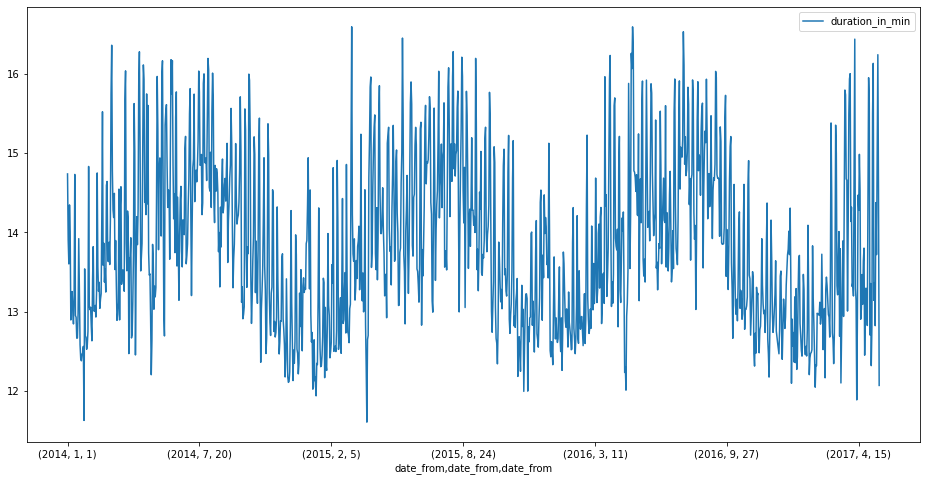

In [88]:
trips.groupby([
    trips.date_from.dt.year,
    trips.date_from.dt.month,
    trips.date_from.dt.day,
    #trips.date_from.dt.hour
]).agg({"duration_in_min": "mean"}).plot(figsize=(16,8))

In [89]:
# Add coordinates to station pairs

pairs = pd.merge(pair_count, stations, left_on="station_x", right_on="name", how="left", sort=False)
pairs.rename(
    columns={
        "latitude": "latitude_x", 
        "longitude": "longitude_x",
    }, 
    inplace=True
)

pairs = pd.merge(pairs, stations, left_on="station_y", right_on="name", how="left", sort=False)
pairs.rename(
    columns={
        "latitude": "latitude_y", 
        "longitude": "longitude_y",
    }, 
    inplace=True
)

pairs.drop(columns=["station_id_x", "name_x", "station_id_y", "name_y"], inplace=True)
pairs

,station_x,station_y,count,longitude_x,latitude_x,neighbour_stations_count_x,longitude_y,latitude_y,neighbour_stations_count_y
0,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,4112,9.982728,53.567845,23,9.982728,53.567845,23
1,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,3273,9.982728,53.567845,23,9.948345,53.563037,20
2,Allende-Platz/Grindelhof,Alsterdorf Markt/Evangelische Stiftung,34,9.982728,53.567845,23,10.023946,53.612091,5
3,Allende-Platz/Grindelhof,Alsterdorfer Straße/Fuhlsbüttler Straße,6,9.982728,53.567845,23,10.032000,53.620000,3
4,Allende-Platz/Grindelhof,Alsterschwimmhalle/Ifflandstraße,647,9.982728,53.567845,23,10.022148,53.560781,22
...,...,...,...,...,...,...,...,...,...
13640,Winterhuder Weg/ Zimmerstraße,Zentralbibliothek / Münzstraße,249,10.020450,53.575308,17,10.008849,53.550332,34
13641,Winterhuder Weg/ Zimmerstraße,Überseering/Mexikoring,377,10.020450,53.575308,17,10.024745,53.601619,8
13642,Zentralbibliothek / Münzstraße,Zentralbibliothek / Münzstraße,789,10.008849,53.550332,34,10.008849,53.550332,34
13643,Zentralbibliothek / Münzstraße,Überseering/Mexikoring,4,10.008849,53.550332,34,10.024745,53.601619,8


In [90]:
sorted_pairs = pairs.sort_values(by="count", ascending=False).reset_index()
sorted_pairs.drop(columns="index", inplace=True)
sorted_pairs

,station_x,station_y,count,longitude_x,latitude_x,neighbour_stations_count_x,longitude_y,latitude_y,neighbour_stations_count_y
0,Bahnhof Altona West / Busbahnhof,Bahrenfelder Straße/Völckersstraße,35315,9.933870,53.551800,17,9.927945,53.556897,15
1,Saarlandstraße/Wiesendamm,Schleidenstraße/Osterbekstraße,28563,10.032680,53.588735,15,10.033690,53.584582,16
2,Mundsburg / Schürbeker Straße,Winterhuder Weg/ Zimmerstraße,22710,10.027100,53.569600,19,10.020450,53.575308,17
3,Am Kaiserkai/Großer Grasbrook,U-Bahn Baumwall,21496,9.992856,53.541838,28,9.980896,53.544279,26
4,Krausestraße/Eilbektal,Lortzingstraße/Friedrichsberger Straße,21366,10.058237,53.576238,11,10.049568,53.573588,16
...,...,...,...,...,...,...,...,...,...
13640,Rothenburgsort/Marktplatz/Lindleystraße,Troplowitzstraße / Beiersdorf / NXP,1,10.038938,53.534288,3,9.957594,53.582793,18
13641,Bahrenfelder Chaussee/Von-Sauer-Straße,Winterhuder Weg/ Zimmerstraße,1,9.910870,53.565973,4,10.020450,53.575308,17
13642,Rothenburgsort/Marktplatz/Lindleystraße,Südring/Stadthallenbrücke,1,10.038938,53.534288,3,10.030327,53.591446,14
13643,Große Rainstraße/Ottenser Hauptstraße,Planetarium/Hindenburgstraße,1,9.930344,53.552339,15,10.013650,53.595950,10


In [143]:
sorted_pairs["count"].quantile(0.9)

1463.0

In [144]:
sorted_pairs["count"].quantile(0.99)

5868.959999999966

In [155]:
sorted_pairs["count"].median()

132.0

In [126]:
sorted_pairs.describe()

,count,longitude_x,latitude_x,neighbour_stations_count_x,longitude_y,latitude_y,neighbour_stations_count_y
count,13645.000000,13645.000000,13645.000000,13645.000000,13645.000000,13645.000000,13645.000000
mean,557.418688,9.994009,53.564077,18.772737,9.998526,53.564850,18.878930
std,1312.619420,0.043241,0.022581,10.748962,0.041571,0.022582,10.381996
min,1.000000,9.862013,53.447625,0.000000,9.862013,53.447625,0.000000
25%,24.000000,9.965669,53.551600,11.000000,9.970330,53.551000,12.000000
50%,132.000000,9.991400,53.560200,18.000000,9.997140,53.563755,18.000000
75%,530.000000,10.022685,53.577579,25.000000,10.027100,53.580004,26.000000
max,35315.000000,10.220000,53.654290,40.000000,10.220000,53.654290,40.000000


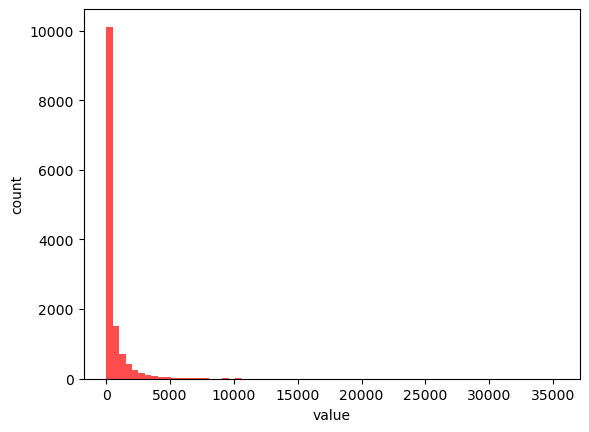

In [137]:
tmp = sorted_pairs[["count"]]
plt.hist(tmp, 70, density=False, color="red", alpha=0.7)
plt.xlabel("value")
plt.ylabel("count")
plt.show()

In [92]:
top_pairs = sorted_pairs[sorted_pairs["count"] >= sorted_pairs["count"].quantile(0.9)]

In [93]:
top_pairs.describe()

,count,longitude_x,latitude_x,neighbour_stations_count_x,longitude_y,latitude_y,neighbour_stations_count_y
count,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000
mean,3329.213606,9.991065,53.561967,21.490124,9.991554,53.561969,21.594001
std,2771.709042,0.033146,0.020678,8.851037,0.032524,0.020839,8.719128
min,1463.000000,9.862013,53.447625,0.000000,9.887159,53.447625,0.000000
25%,1829.000000,9.969214,53.552244,15.000000,9.969250,53.552244,15.000000
50%,2445.000000,9.989710,53.561109,20.000000,9.987659,53.562709,21.000000
75%,3729.500000,10.014402,53.575491,26.000000,10.014900,53.575308,27.000000
max,35315.000000,10.206105,53.654290,40.000000,10.220000,53.648757,40.000000


In [94]:
top_pairs.head(10)

,station_x,station_y,count,longitude_x,latitude_x,neighbour_stations_count_x,longitude_y,latitude_y,neighbour_stations_count_y
0,Bahnhof Altona West / Busbahnhof,Bahrenfelder Straße/Völckersstraße,35315,9.933870,53.551800,17,9.927945,53.556897,15
1,Saarlandstraße/Wiesendamm,Schleidenstraße/Osterbekstraße,28563,10.032680,53.588735,15,10.033690,53.584582,16
2,Mundsburg / Schürbeker Straße,Winterhuder Weg/ Zimmerstraße,22710,10.027100,53.569600,19,10.020450,53.575308,17
3,Am Kaiserkai/Großer Grasbrook,U-Bahn Baumwall,21496,9.992856,53.541838,28,9.980896,53.544279,26
4,Krausestraße/Eilbektal,Lortzingstraße/Friedrichsberger Straße,21366,10.058237,53.576238,11,10.049568,53.573588,16
5,Am Kaiserkai/Großer Grasbrook,Landungsbrücke/Hafentor,20317,9.992856,53.541838,28,9.972300,53.545700,22
6,Hallerstraße / Rohtenbaumchaussee,Universität / Schlüterstraße,19767,9.988801,53.572081,18,9.986076,53.566972,21
7,Eppendorfer Baum / Isestraße,Martinistraße / Haupteingang Klinikum,19511,9.984410,53.583200,16,9.975715,53.588918,14
8,Kellinghusenstraße / Loogeplatz,Martinistraße / Haupteingang Klinikum,18974,9.991125,53.588516,13,9.975715,53.588918,14
9,Jarrestraße / Rambatzweg,Mundsburg / Schürbeker Straße,18640,10.021100,53.584000,15,10.027100,53.569600,19


In [95]:
config = eval(open("config/map_config_most_popular.py", "r").read())
map = KeplerGl(height=700, data={"data": top_pairs, "stations": stations}, config=config)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'mz5vtjc', 'type': …

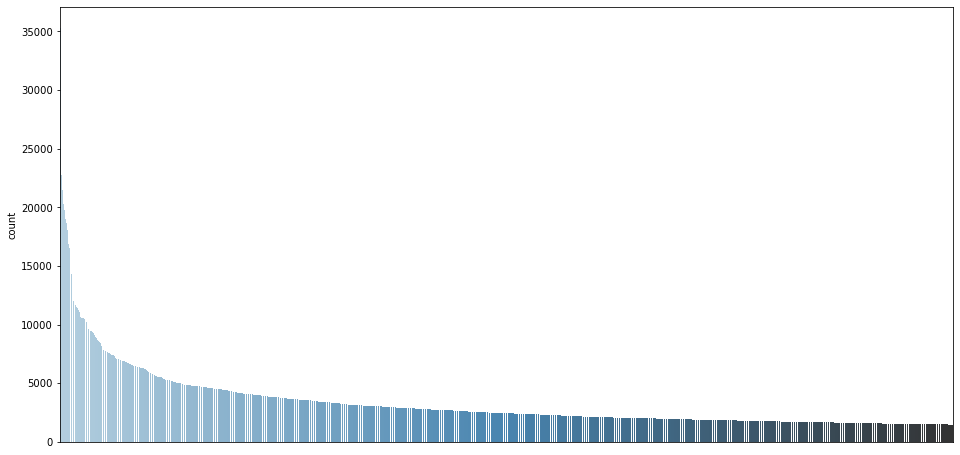

In [96]:
plt.figure(figsize=(16, 8))
ax = sns.barplot(y="count", x=top_pairs.index, data=top_pairs, palette="Blues_d")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig("figures/stations_top_dist.png", bbox_inches="tight")
plt.show()